# XGBoost Example

## Ejemplo Didáctico

En este notebook vamos a llevar a cabo la implementación del algoritmo gradient boosting.

## Obtener dependencias
Cuando no tengamos dependencias disponibles tenemos que descargarlas a traves de pip.

### Librerías
Aquí vamos a incluir todas las dependencias del código que tengamos con las librerías externas. 

In [7]:
from io import StringIO
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV # Creación de conjuntos aleatorios. Y optimización de hiperparámetros
from xgboost import XGBClassifier # Modelo de clasificacion.

# Procesamiento de datos:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Metricas de evaluación.
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score,
    roc_curve,
)

### Constants
Aquí declaramos las constantes que vayamos a utilizar en el código. 

In [8]:
SEED = 11
processor_filename = './process_info.pkl'
model_filename = './modelo_xgboost.pkl'
dataset_path = '../../data/xgboost-example/data.csv' # Cambien esto por el path de su archivo

data_path = '../../data/xgboost-example/diabetic_data.csv' 
data_ids_path = '../../data/xgboost-example/IDS_mapping.csv'
codes_json = '../../data/xgboost-example/codes.json'
data_description  = '../../data/xgboost-example/field_description.txt'

### Funciones
En caso de crear alguna función, es necesario que estén juntas para facilitar la lectura del código. 

In [9]:
def read_txt(filepath):
    with open(filepath, 'r') as file:
        f = file.read()
    return f

def read_json_data(path_to_file):
    with open(path_to_file, 'r') as f:
        json_data = json.load(f)
    return json_data

def icd9_code_process(codes):
    codes_df = pd.DataFrame(codes)
    code_df_columns = codes_df.columns

    for col in code_df_columns:
        codes_df.loc[:, f'code_depth{col}__descr'] = codes_df[col].apply(
            get_dict_information, string='descr')
        codes_df.loc[:, f'code_depth{col}__code_range'] = codes_df[col].apply(
            get_dict_information, string='code')

    codes_df.drop(code_df_columns, axis=1, inplace=True)
    key_val_col = 'code_depth2__code_range'
    relevant_depth_cols = [key_val_col, 'code_depth2__descr',
                           'code_depth1__descr', 'code_depth0__descr']
    code_depth_dict = codes_df[relevant_depth_cols].set_index(
        key_val_col).drop_duplicates().to_dict()
    return code_depth_dict

def get_dict_information(possible_dict, string=None):
    response = ''
    if isinstance(possible_dict, dict):
        response = possible_dict.get(string)
    return response

### Contexto

Diabetes 130-US hospitals for years 1999-2008. The dataset was donated on 5/2/2014

The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. **The goal is to determine the early readmission of the patient within 30 days of discharge.** The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

- What do the instances in this dataset represent?
    - The instances represent hospitalized patient records diagnosed with diabetes.

---
- Are there recommended data splits?
    - No recommendation. The standard train-test split could be used. Can use three-way holdout split (i.e., train-validation-test) when doing model selection.

---
- Does the dataset contain data that might be considered sensitive in any way?
    - Yes. The dataset contains information about the age, gender, and race of the patients.
      
---
- Additional Information
    - The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria. (1) It is an inpatient encounter (a hospital admission). (2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered into the system as a diagnosis. (3) The length of stay was at least 1 day and at most 14 days. (4) Laboratory tests were performed during the encounter. (5) Medications were administered during the encounter.

    - The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab tests performed, HbA1c test result, diagnosis, number of medications, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.
---
Complementary information provided in the following [paper](https://onlinelibrary.wiley.com/doi/10.1155/2014/781670).

### Código
Una vez que definimos las dependencias, las constantes y las funciones podemos comenzar a procesar los datos a través del código

### Configuración
Aquí vamos a poner configuraciones en general

In [10]:
warnings.filterwarnings('ignore')
colormap = matplotlib.cm.binary
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

#### Lectura de datos

In [11]:
icd9_codes

In [15]:
data_descr

,Variable Name,Role,Type,Demographic,Description,Units,Missing Values
0,encounter_id,ID,NaN,NaN,Unique identifier of an encounter,NaN,no
1,patient_nbr,ID,NaN,NaN,Unique identifier of a patient,NaN,no
2,race,Feature,Categorical,Race,"Values: Caucasian, Asian, African American, Hispanic, and other",NaN,yes
3,gender,Feature,Categorical,Gender,"Values: male, female, and unknown/invalid",NaN,no
4,age,Feature,Categorical,Age,"Grouped in 10-year intervals: [0, 10), [10, 20),..., [90, 100)",NaN,no
5,weight,Feature,Categorical,NaN,Weight in pounds.,NaN,yes
6,admission_type_id,Feature,Categorical,NaN,"Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective,...",NaN,no
7,discharge_disposition_id,Feature,Categorical,NaN,"Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired...",NaN,no
8,admission_source_id,Feature,Categorical,NaN,"Integer identifier corresponding to 21 distinct values, for example, physician referral, emergen...",NaN,no
9,time_in_hospital,Feature,Integer,NaN,Integer number of days between admission and discharge,NaN,no


In [17]:
#icd9_codes

In [14]:
icd9_codes = read_json_data(codes_json)# Codigos de diagnóstico
data_ids_txt = read_txt(data_ids_path)
data_descr = pd.read_csv(data_description, sep='|') # Descripción de las varibles
data = pd.read_csv(data_path) # datos

In [75]:
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223529,33735900,2261385,Hispanic,Female,[40-50),?,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
223530,384887420,46020915,Caucasian,Male,[60-70),?,3,1,1,3,...,No,No,No,No,No,No,No,No,No,<30
223531,168337386,24122547,AfricanAmerican,Male,[70-80),?,1,11,7,2,...,No,No,No,No,No,No,No,No,No,NO
223532,39335172,11529045,Caucasian,Female,[80-90),?,1,18,7,6,...,No,No,No,No,No,No,No,Ch,Yes,NO


In [74]:
#data

In [18]:
data = data[data_descr['Variable Name']]

#### EDA

In [19]:
data_ids_txt_list = {pd.read_csv(StringIO(individual)).columns[0]: pd.read_csv(StringIO(individual)) for individual in data_ids_txt.split('\n,\n')}

In [9]:
data_ids_txt_list.keys()
data_ids_txt_list['discharge_disposition_id']

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution
5,6,Discharged/transferred to home with home health service
6,7,Left AMA
7,8,Discharged/transferred to home under care of Home IV provider
8,9,Admitted as an inpatient to this hospital
9,10,Neonate discharged to another hospital for neonatal aftercare


In [10]:
# Hospice: A program that gives special care to people who are near the end of life and have stopped treatment to cure or control their disease.
# Expired: Death. 

In [20]:
# Transformations to data
data_copy = data.copy()
for key, df in data_ids_txt_list.items():
    data_copy = data_copy.merge(df.rename(columns={'description': f'{key}_descr'}), on=key)
data_copy = data_copy[~(
    #(data_copy.discharge_disposition_id_descr.fillna('nan').str.lower().str.contains('hospice')) |
    (data_copy.discharge_disposition_id_descr.fillna('nan').str.lower().str.contains('expired')) 
)]

<Axes: ylabel='Frequency'>

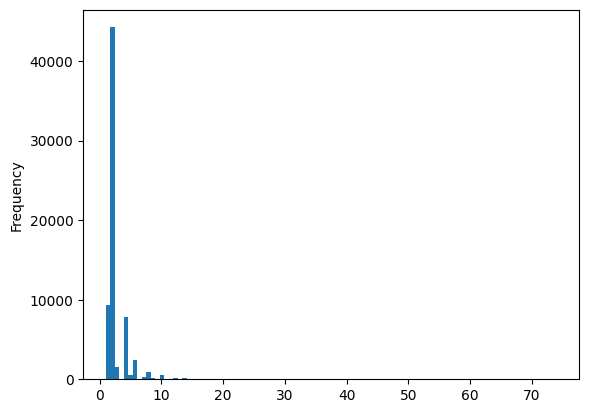

In [24]:
data_copy.patient_nbr.value_counts().plot(kind='hist', bins=100)

In [25]:
# La mayoria de la informacion se mantiene, si bien las visitas son independientes, no lo es la 
data_copy[data_copy.patient_nbr == 88785891]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_id_descr,discharge_disposition_id_descr,admission_source_id_descr
64274,119039172,88785891,Caucasian,Female,[20-30),?,1,1,7,1,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
64786,125094312,88785891,Caucasian,Female,[20-30),?,1,1,7,1,...,No,No,No,No,Ch,Yes,<30,Emergency,Discharged to home,Emergency Room
64886,126171582,88785891,Caucasian,Female,[20-30),?,1,1,7,5,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
66181,139425576,88785891,Caucasian,Female,[20-30),?,1,1,7,2,...,No,No,No,No,Ch,Yes,<30,Emergency,Discharged to home,Emergency Room
67655,151413846,88785891,Caucasian,Female,[20-30),?,1,1,7,4,...,No,No,No,No,Ch,Yes,<30,Emergency,Discharged to home,Emergency Room
70431,168920160,88785891,Caucasian,Female,[20-30),?,1,1,7,8,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
71118,174689286,88785891,Caucasian,Female,[20-30),?,1,1,7,3,...,No,No,No,No,Ch,Yes,<30,Emergency,Discharged to home,Emergency Room
71969,183194856,88785891,Caucasian,Female,[20-30),?,1,1,7,2,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
75904,239153370,88785891,Caucasian,Female,[20-30),?,1,1,7,7,...,No,No,No,No,Ch,Yes,<30,Emergency,Discharged to home,Emergency Room
76090,241426656,88785891,Caucasian,Female,[20-30),?,1,1,7,3,...,No,No,No,No,Ch,Yes,<30,Emergency,Discharged to home,Emergency Room


In [26]:
unique_patients = data_copy.patient_nbr.unique()

In [30]:
train_patients, test_patients = train_test_split(unique_patients, train_size=0.7, random_state=SEED) # División en 70-30
test_patients, val_patients = train_test_split(test_patients, train_size=0.5, random_state=SEED) # del 30, división 50-50, es decir del total 15-15
val_patients, esr_patients = train_test_split(val_patients, train_size=0.5, random_state=SEED) # del 15, división 50-50, es decir del total 7.5-75

#### Caso de uso inventado: Clasificación binaria
El objetivo es determinar la admisión temprana de un paciente (menor a 30 días).

In [31]:
raw_train = data_copy[data_copy.patient_nbr.isin(train_patients)]
raw_test = data_copy[data_copy.patient_nbr.isin(test_patients)]
raw_val = data_copy[data_copy.patient_nbr.isin(val_patients)]
raw_esr = data_copy[data_copy.patient_nbr.isin(esr_patients)]

In [32]:
def get_midpoint_val(val):
    if '[' and ')' in val:
        nb_list = list(map(lambda x: int(x), val.replace('[', '').replace(')', '').split('-')))
        mid_point = (nb_list[0] + nb_list[1])//2
    elif '>' in val:
        mid_point = int(val.replace('>', ''))
    elif '?' in val:
        mid_point=np.nan
    else:
        mid_point = np.nan
    return mid_point

def create_index(row):
    index = str(row.patient_nbr) + '_' + str(row.encounter_id)
    return index

def apply_gender_transformation(gender):
    if gender =='Male':
        return 0
    if gender == 'Female':
        return 1
    return -1

def get_words_from_cammelcase(words):
    regexp = r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))'
    value = re.findall(regexp, words)
    return value

def get_numerical_results_from_study(study):
    if study is None:
        return np.nan
    if study =='Norm':
        return 1
    if '>' in study:
        return int(study.replace('>', ''))

yes_no_dict = {'Yes': 1, 'No': 0}
dosis_dict = {'Steady': 1, 'No': -1, 'Up': 2, 'Down': 0}
response_var_dict = {'NO':0, '>30': 0, '<30': 1}
components = 5

In [33]:
codes = pd.DataFrame(icd9_code_process(icd9_codes))
codes['all_code'] = (
    codes['code_depth0__descr'].str.lower().fillna('') + ' ' + codes['code_depth1__descr'].str.lower().fillna('') +
    ' ' + codes['code_depth2__descr'].str.lower().fillna('')
) 
codes = codes.reset_index()

In [35]:
#codes

In [36]:
def transform_data(data, is_train=False, transformations=False):
    raw_data = data.copy()
    raw_data['index'] = raw_data.apply(create_index, axis=1)
    raw_data.set_index('index', inplace=True)
    raw_data_index = raw_data.index
    raw_data.drop(
        ['encounter_id','patient_nbr'], axis=1, inplace=True
    )
    raw_data['weight'] = raw_data.weight.apply(get_midpoint_val)
    raw_data['age'] = raw_data.age.apply(get_midpoint_val)
    #¿La raza puede tener relevancia médica?
    raw_data.drop('race', axis=1, inplace=True)# ¿Dejar o quitar? El modelo podría ser racista por cuestiones históricas? 
    # Y el género puede tener relevancia médica?
    raw_data['gender'] = raw_data.gender.apply(apply_gender_transformation)
    raw_data.drop('payer_code', axis=1, inplace=True)# ¿Dejar o quitar el código de pagador? 
    raw_data['total_procedures'] = raw_data['num_lab_procedures'] + raw_data['num_procedures']
    raw_data['percentage_lab_procedures'] = raw_data['num_lab_procedures'] / raw_data['total_procedures']
    raw_data['total_procedures_over_time_in_hospital'] = raw_data['total_procedures'] / raw_data['time_in_hospital']
    raw_data['diabetesMed'] = raw_data.diabetesMed.map(yes_no_dict)
    raw_data['total_cares'] = raw_data['number_inpatient'] + raw_data['number_outpatient'] + raw_data['number_emergency']
    raw_data['max_glu_serum'] = raw_data.max_glu_serum.apply(get_numerical_results_from_study).value_counts()
    raw_data['A1Cresult'] = raw_data.A1Cresult.apply(get_numerical_results_from_study).value_counts()
    raw_data['change'] = raw_data.change.str.replace('Ch', 'Yes').map(yes_no_dict)
    
    medicine_doses = ['metformin', 'repaglinide', 'nateglinide',
           'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
           'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
           'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
           'insulin', 'glyburide-metformin', 'glipizide-metformin',
           'glimepiride-pioglitazone', 'metformin-rosiglitazone',
           'metformin-pioglitazone',]
    
    for med in medicine_doses:
        raw_data[med] = raw_data[med].map(dosis_dict)
    if is_train:
        pca_medicine_doses = PCA(n_components=components)
        pca_medicine_doses.fit(raw_data[medicine_doses])
    else: 
        pca_medicine_doses = transformations['medical_doses']['pca']
        
    pca_medicine_doses_data = pd.DataFrame(
        pca_medicine_doses.transform(raw_data[medicine_doses]), 
        columns=[f'pca_medicine{i}' for i in range(components)],
        index=raw_data_index
    )
    corpus = raw_data.medical_specialty.replace('?', 'Other').apply(get_words_from_cammelcase).apply(lambda x: ' '.join(x))

    if is_train:
        tfidf_vectorizer_medical_specialty = TfidfVectorizer()
        tfidf_vectorizer_medical_specialty.fit(corpus)
    else: 
        tfidf_vectorizer_medical_specialty = transformations['medical_specialty']['tfidf']
        
    tfidf_data_medical_speciality = pd.DataFrame(
        tfidf_vectorizer_medical_specialty.transform(corpus).toarray(),
        columns=tfidf_vectorizer_medical_specialty.get_feature_names_out()
    )
    if is_train:
        pca_medical_speciality = PCA(n_components=components)
        pca_medical_speciality.fit(tfidf_data_medical_speciality)
    else: 
        pca_medical_speciality = transformations['medical_specialty']['pca']
        
    pca_medical_speciality_data = pd.DataFrame(
        pca_medical_speciality.transform(tfidf_data_medical_speciality), 
        columns=[f'pca_medical_speciality{i}' for i in range(components)],
        index=raw_data_index
    )
    raw_data.drop('medical_specialty', axis=1, inplace=True)
    words = (
        raw_data.admission_source_id_descr.fillna('Nothing') + ' ' + 
        raw_data.discharge_disposition_id_descr.fillna('Nothing') + ' ' + 
        raw_data.admission_type_id_descr.fillna('Nothing')
    )
    corpus_ids = words.str.replace(
        '\W', ' '
    ).str.replace(
        '  ', ' '
    ).str.lower().str.strip().str.split(
        ' '
    ).apply(
        lambda x: ' '.join(x)
    )

    if is_train:
        stopwords = ['to', 'a', 'from', 'of', 'this', 'a', 'an', 'in', 'or', 'as', 'with']
        tfidf_vectorizer_ids = TfidfVectorizer(stop_words=stopwords)
        tfidf_vectorizer_ids.fit(corpus_ids)
    else: 
        tfidf_vectorizer_ids = transformations['ids']['tfidf']
    
    tfidf_data_ids = pd.DataFrame(
        tfidf_vectorizer_ids.transform(corpus_ids).toarray(),
        columns=tfidf_vectorizer_ids.get_feature_names_out()
    )

    if is_train:
        pca_ids = PCA(n_components=components)
        pca_ids.fit(tfidf_data_ids)
        
    else: 
        pca_ids = transformations['ids']['pca']
    
    pca_ids_data = pd.DataFrame(
        pca_ids.transform(tfidf_data_ids), 
        columns=[f'pca_ids{i}' for i in range(components)],
        index=raw_data_index
    )
    
    raw_data.drop(
        ['admission_source_id_descr', 
         'discharge_disposition_id_descr', 
         'admission_type_id_descr',
         'admission_source_id', 
         'discharge_disposition_id',
         'admission_type_id'], axis=1, inplace=True)

    raw_data['clean_diag_1'] = raw_data['diag_1'].str.split('.').apply(lambda x: x[0].zfill(3))
    raw_data['clean_diag_2'] = raw_data['diag_2'].str.split('.').apply(lambda x: x[0].zfill(3))
    raw_data['clean_diag_3'] = raw_data['diag_3'].str.split('.').apply(lambda x: x[0].zfill(3))
    
    raw_data = raw_data.merge(
        codes[['index', 'all_code']], left_on='clean_diag_1', right_on='index', how='left'
    ).drop(['index', 'diag_1', 'clean_diag_1'], axis=1).rename(columns={'all_code': 'diagnostic_1'}
    ).merge(
        codes[['index', 'all_code']], left_on='clean_diag_2', right_on='index', how='left'
    ).drop(['index', 'diag_2', 'clean_diag_2'], axis=1).rename(columns={'all_code': 'diagnostic_2'}
    ).merge(
        codes[['index', 'all_code']], left_on='clean_diag_3', right_on='index', how='left'
    ).drop(['index', 'diag_3', 'clean_diag_3'], axis=1).rename(columns={'all_code': 'diagnostic_3'}
    )

    raw_data.index = raw_data_index
    
    raw_data['all_diagnostics'] = (
        raw_data['diagnostic_1'].fillna('') + ' ' + 
        raw_data['diagnostic_2'].fillna('') + ' ' + 
        raw_data['diagnostic_3'].fillna('')
    )
    
    corpus_diag = raw_data.all_diagnostics
    if is_train:
        tfidf_vectorizer_diagnostic = TfidfVectorizer()
        tfidf_vectorizer_diagnostic.fit(corpus)
    else: 
        tfidf_vectorizer_diagnostic = transformations['diagnostic']['tfidf']
        
    tfidf_data_diagnostic = pd.DataFrame(
        tfidf_vectorizer_diagnostic.transform(corpus_diag).toarray(),
        columns=tfidf_vectorizer_diagnostic.get_feature_names_out()
    )
    if is_train:
        pca_diagnostic = PCA(n_components=components)
        pca_diagnostic.fit(tfidf_data_diagnostic)
    else: 
        pca_diagnostic = transformations['diagnostic']['pca']

    pca_diagnostic_data = pd.DataFrame(
        pca_diagnostic.transform(tfidf_data_diagnostic), 
        columns=[f'pca_diagnostic{i}' for i in range(components)],
        index=raw_data_index
    )
    raw_data.drop(['all_diagnostics', 'diagnostic_1', 'diagnostic_2', 'diagnostic_3'], axis=1, inplace=True)

    #################
    #return pca_medicine_doses_data, pca_medical_speciality_data, pca_ids_data, pca_diagnostic_data
    raw_data = pd.concat(
        [pca_medicine_doses_data, pca_medical_speciality_data, pca_ids_data, pca_diagnostic_data, raw_data.drop(medicine_doses, axis=1)],
        axis=1
    )

    x_data = raw_data.drop('readmitted', axis=1).astype('float')
    y_data = raw_data.readmitted.map(response_var_dict)
    dataset = x_data, y_data 
    transformations = {
        'medical_doses': {
            'pca': pca_medicine_doses
        },  
        'medical_specialty': {
            'pca': pca_medical_speciality,
            'tfidf': tfidf_vectorizer_medical_specialty,
        },
        'ids': {
            'pca': pca_ids,
            'tfidf':tfidf_vectorizer_ids
        },
        'diagnostic': {
            'pca': pca_diagnostic,
            'tfidf': tfidf_vectorizer_diagnostic
        }
    } 
    if is_train: 
        return dataset, transformations
    return dataset

In [80]:
x_train

,pca_medicine0,pca_medicine1,pca_medicine2,pca_medicine3,pca_medicine4,pca_medical_speciality0,pca_medical_speciality1,pca_medical_speciality2,pca_medical_speciality3,pca_medical_speciality4,...,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,total_procedures,percentage_lab_procedures,total_procedures_over_time_in_hospital,total_cares
index,,,,,,,,,,,,,,,,,,,,,
8222157_2278392,-1.024385,-0.550810,-0.104059,-0.236171,-0.077056,0.370269,-0.165480,-0.000860,0.099683,0.167310,...,0.0,1.0,NaN,NaN,0.0,0.0,41.0,1.000000,41.000000,0.0
720936_1968528,-0.027109,-0.496128,-0.112250,-0.188138,-0.079783,0.395337,-0.211666,-0.055194,0.096386,0.468032,...,0.0,9.0,NaN,NaN,1.0,1.0,58.0,0.965517,5.800000,0.0
558360_2223336,-1.024385,-0.550810,-0.104059,-0.236171,-0.077056,0.393606,-0.195235,-0.001162,0.147089,0.405562,...,0.0,8.0,NaN,NaN,0.0,0.0,65.0,0.923077,7.222222,0.0
2519748_2298006,-0.026133,-0.308817,-0.071010,-0.159718,-0.816256,0.718028,0.684293,0.000958,-0.061690,-0.044683,...,0.0,8.0,NaN,NaN,1.0,1.0,47.0,1.000000,11.750000,0.0
608841_2356308,0.970168,-0.441446,-0.120440,-0.140105,-0.082509,0.504827,-0.498364,-0.645012,-0.329075,-0.288051,...,0.0,8.0,NaN,NaN,0.0,1.0,50.0,1.000000,50.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53141841_303087224,0.885455,1.483102,-0.221404,-0.614501,-0.097596,-0.544361,0.050028,0.000158,-0.012348,-0.010825,...,1.0,9.0,NaN,NaN,1.0,1.0,36.0,1.000000,3.600000,1.0
58752171_310142636,1.967445,-0.386763,-0.128631,-0.092072,-0.085236,-0.544361,0.050028,0.000158,-0.012348,-0.010825,...,4.0,8.0,NaN,NaN,1.0,1.0,39.0,1.000000,3.250000,6.0
37459422_345401582,0.885455,1.483102,-0.221404,-0.614501,-0.097596,0.370000,-0.165202,-0.000887,0.099378,0.166472,...,1.0,7.0,NaN,NaN,1.0,1.0,37.0,1.000000,2.642857,1.0


In [37]:
processsed_train_data, transformations = transform_data(raw_train, is_train=True, transformations=False)
x_train, y_train = processsed_train_data

In [38]:
x_test, y_test = transform_data(raw_test, transformations=transformations)
x_validate, y_validate = transform_data(raw_val, transformations=transformations)
x_esr, y_esr = transform_data(raw_esr, transformations=transformations)

##### Entrenamiento del modelo
Vamos ahora a entrenar el modelo con la información del conjunto de entrenamiento

In [50]:
# Definimos el modelo que queremos entrenar
model = XGBClassifier()

# Encontramos lista de parametros relevantes para el modelo
max_depth = [2, 4, 6]
max_leaves = [0]
learning_rate = [1.0, 0.1, 0.01, 0.001]
gamma = [0, 1, 10]
reg_alpha = [0, 1, 100]
reg_lambda = [0, 1, 100]
subsample = [0.8]
colsample_bytree = [0.8]
colsample_level = [0.8]
scale_pos_weight = [(y_train == 0).sum()/(y_train == 1).sum()]
early_stopping_rounds = [100]
eval_metric = ['auc']
n_estimators = [100000]


grid = dict(
    max_depth=max_depth, 
    max_leaves=max_leaves, 
    learning_rate=learning_rate,
    gamma=gamma,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=early_stopping_rounds,
    n_estimators=n_estimators,
    eval_metric=eval_metric,
)

# Hacemos una optimizacion de hiperparametros, con un conjunto pequeño.
params_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=grid,
    n_iter=40,
    n_jobs=-1, 
    scoring='roc_auc', 
    error_score=0,
    random_state=SEED
)

In [51]:
param_search_result = params_search.fit(x_validate, y_validate, eval_set=[(x_esr, y_esr)])
#grid_result.cv_results_

[0]	validation_0-auc:0.55153
[1]	validation_0-auc:0.55411
[2]	validation_0-auc:0.56582
[3]	validation_0-auc:0.57467
[4]	validation_0-auc:0.57164
[0]	validation_0-auc:0.57436
[5]	validation_0-auc:0.57505
[6]	validation_0-auc:0.57252
[1]	validation_0-auc:0.59141
[0]	validation_0-auc:0.56380
[7]	validation_0-auc:0.57586
[2]	validation_0-auc:0.61003
[1]	validation_0-auc:0.57562
[8]	validation_0-auc:0.57826
[3]	validation_0-auc:0.61480
[2]	validation_0-auc:0.57069
[9]	validation_0-auc:0.58166
[4]	validation_0-auc:0.61255
[3]	validation_0-auc:0.57128
[5]	validation_0-auc:0.61550
[10]	validation_0-auc:0.58887
[0]	validation_0-auc:0.58279
[6]	validation_0-auc:0.61992
[11]	validation_0-auc:0.59190
[4]	validation_0-auc:0.56968
[1]	validation_0-auc:0.57708
[7]	validation_0-auc:0.62503
[5]	validation_0-auc:0.57548
[12]	validation_0-auc:0.59388
[2]	validation_0-auc:0.58252
[6]	validation_0-auc:0.57615
[8]	validation_0-auc:0.62581
[13]	validation_0-auc:0.59311
[7]	validation_0-auc:0.57998
[9]	valida

In [52]:
best_params = param_search_result.best_estimator_.get_params()
best_params

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': 100,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': 1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': 0,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 100,
 'reg_lambda': 100,
 'sampling_method': None,
 'scale_pos_weight': 7.841658341658341,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [53]:
clf = XGBClassifier(**best_params)
clf.fit(x_train, y_train, eval_set=[(pd.concat([x_esr, x_validate], axis=0), pd.concat([y_esr, y_validate], axis=0))])

[0]	validation_0-auc:0.61876
[1]	validation_0-auc:0.63606
[2]	validation_0-auc:0.63097
[3]	validation_0-auc:0.63377
[4]	validation_0-auc:0.63292
[5]	validation_0-auc:0.63297
[6]	validation_0-auc:0.63285
[7]	validation_0-auc:0.63280
[8]	validation_0-auc:0.63278
[9]	validation_0-auc:0.63266
[10]	validation_0-auc:0.63326
[11]	validation_0-auc:0.63341
[12]	validation_0-auc:0.63329
[13]	validation_0-auc:0.63341
[14]	validation_0-auc:0.63329
[15]	validation_0-auc:0.63340
[16]	validation_0-auc:0.63347
[17]	validation_0-auc:0.63340
[18]	validation_0-auc:0.63377
[19]	validation_0-auc:0.63373
[20]	validation_0-auc:0.63459
[21]	validation_0-auc:0.63419
[22]	validation_0-auc:0.63415
[23]	validation_0-auc:0.63445
[24]	validation_0-auc:0.63435
[25]	validation_0-auc:0.63425
[26]	validation_0-auc:0.63433
[27]	validation_0-auc:0.63440
[28]	validation_0-auc:0.63583
[29]	validation_0-auc:0.63591
[30]	validation_0-auc:0.63597
[31]	validation_0-auc:0.63586
[32]	validation_0-auc:0.63586
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [54]:
# Salvemos modelo
with open(model_filename, 'wb') as file:
    pickle.dump(clf, file)

##### Evaluemos el entrenamiento
Vamos entonces a evaluar el desempeño del modelo, respecto al conjunto de entrenamiento. 



In [55]:
pred_train = clf.predict_proba(x_train)[:, 1]
pred_val = clf.predict_proba(x_validate)[:, 1]
pred_test = clf.predict_proba(x_test)[:, 1]

In [56]:
roc_auc_score(y_train, pred_train)

0.6889092131811998

In [57]:
roc_auc_score(y_validate, pred_val)

0.6635103613158924

In [58]:
roc_auc_score(y_test, pred_test)

0.6784793568234189

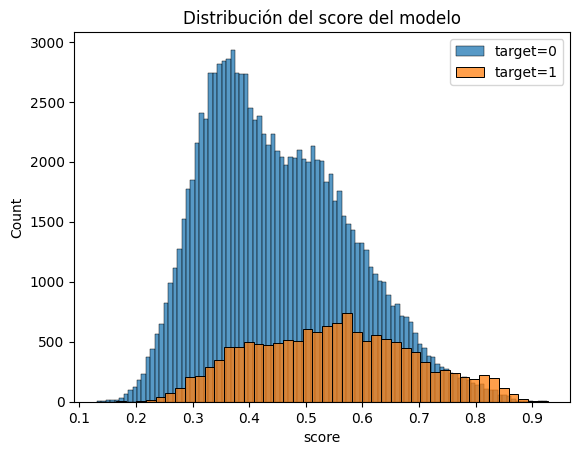

In [59]:
sns.histplot(pred_train[y_train==0], label='target=0')
sns.histplot(pred_train[y_train==1], label='target=1')
plt.title('Distribución del score del modelo')
plt.xlabel('score')
plt.legend()

In [62]:
visual_cutpoint = 0.8

In [63]:
accuracy_score(y_train, pred_train > visual_cutpoint)

0.8860193532245959

In [64]:
precision_score(y_train, pred_train > visual_cutpoint)

0.46364242828552366

In [65]:
recall_score(y_train, pred_train > visual_cutpoint)

0.04959326387897817

In [66]:
f1_score(y_train, pred_train > visual_cutpoint)

0.08960226906465546

In [67]:
print(classification_report(y_train, pred_train > visual_cutpoint))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    109893
           1       0.46      0.05      0.09     14014

    accuracy                           0.89    123907
   macro avg       0.68      0.52      0.51    123907
weighted avg       0.84      0.89      0.84    123907



<Axes: >

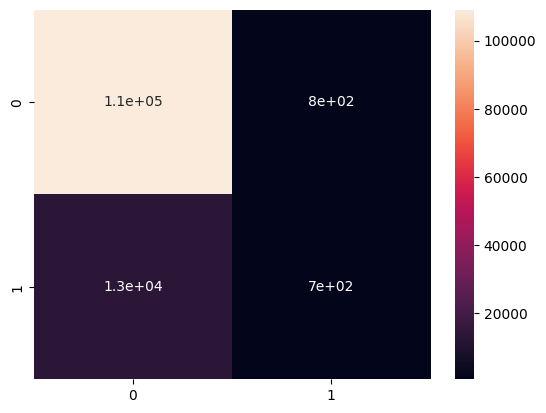

In [68]:
sns.heatmap(confusion_matrix(y_train, pred_train > visual_cutpoint), annot=True)

##### Evaluemos la prueba
Vamos entonces a evaluar el desempeño del modelo, respecto al conjunto de prueba. 

In [39]:
roc_auc_score(y_test, pred_test)

0.6531944872249753

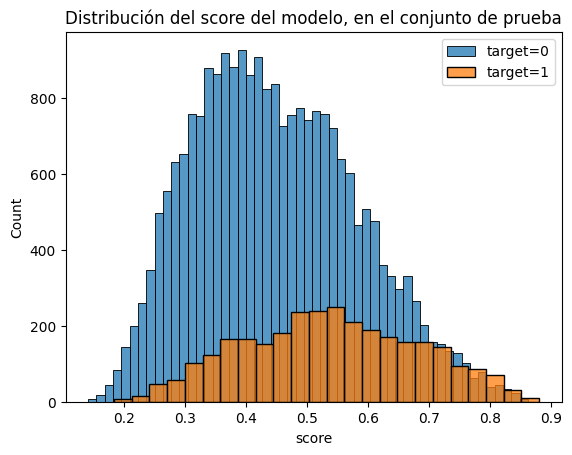

In [72]:
sns.histplot(pred_test[y_test==0], label='target=0')
sns.histplot(pred_test[y_test==1], label='target=1')
plt.title('Distribución del score del modelo, en el conjunto de prueba')
plt.xlabel('score')
plt.legend()

In [73]:
print(classification_report(y_test, pred_test > visual_cutpoint))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     23530
           1       0.43      0.03      0.06      3052

    accuracy                           0.88     26582
   macro avg       0.66      0.51      0.50     26582
weighted avg       0.84      0.88      0.84     26582

